# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Camera Calibration

To correctly display the size and shapes of 3d objects we first have to take into account the distortion inherent to the camera's setting. We start by calculating the distortion coefficients by looking at images of pre-defined checkboard patterns:

In [34]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import os
%matplotlib inline

rcParams['axes.titlepad'] = 20 
rcParams['xtick.labelsize'] = 20 # fontsize of the tick labels
rcParams['ytick.labelsize'] = 20 # fontsize of the tick labels
rcParams['figure.subplot.hspace'] = 0.3 # fontsize of the tick labels

In [24]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In the previous step we searched for checkboard corners using cv2's built-int *drawChessboardCorners* function. Next we will apply *calibrateCamera* on the object points and corresponding image points to find the matrices used to undistort images produced with our camera

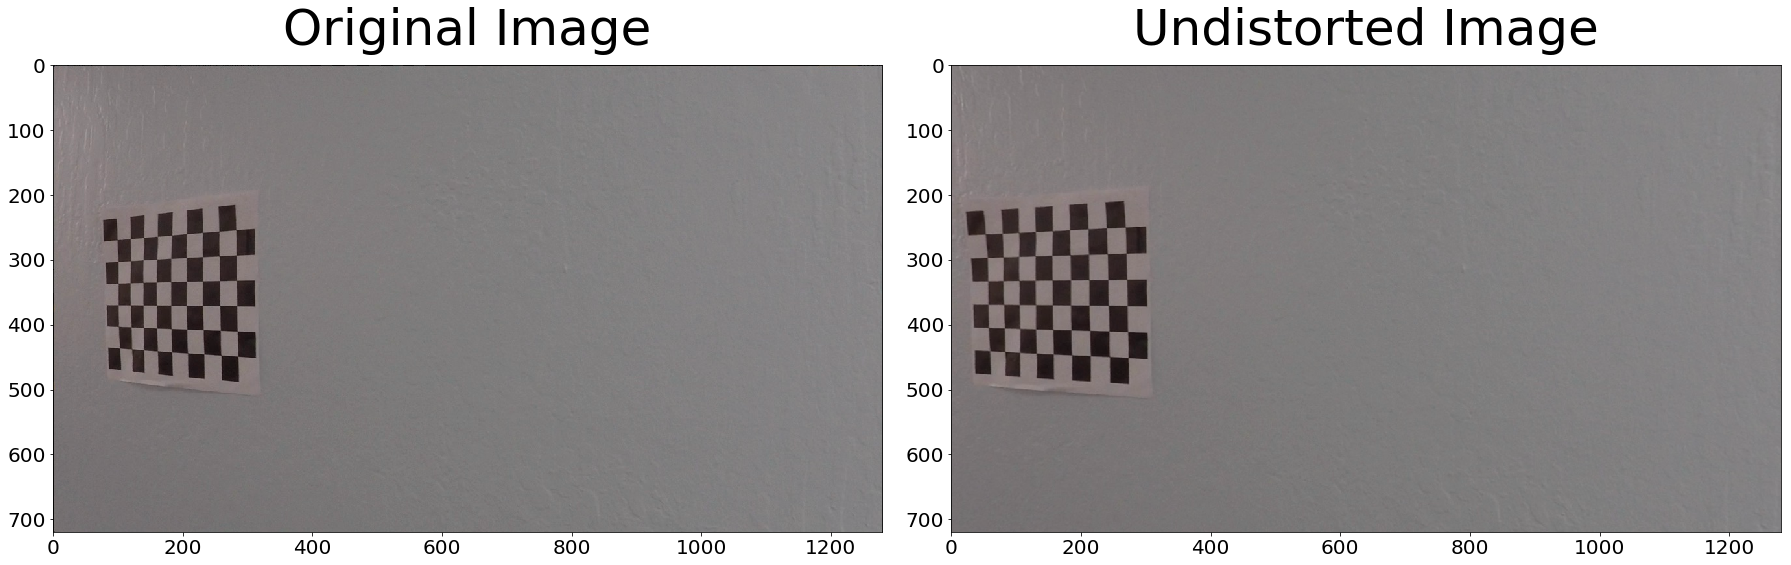

In [48]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


image=cv2.imread(images[2])
undistorted = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Let's clean up the cal_undistort function by using the calibration parameter as global variables to make it easier to use later on:

In [49]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
def undistort_image(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Lane Detection Pipeline

Now that the camera is correctly calibrated, we can have a look at some undistorted test images:

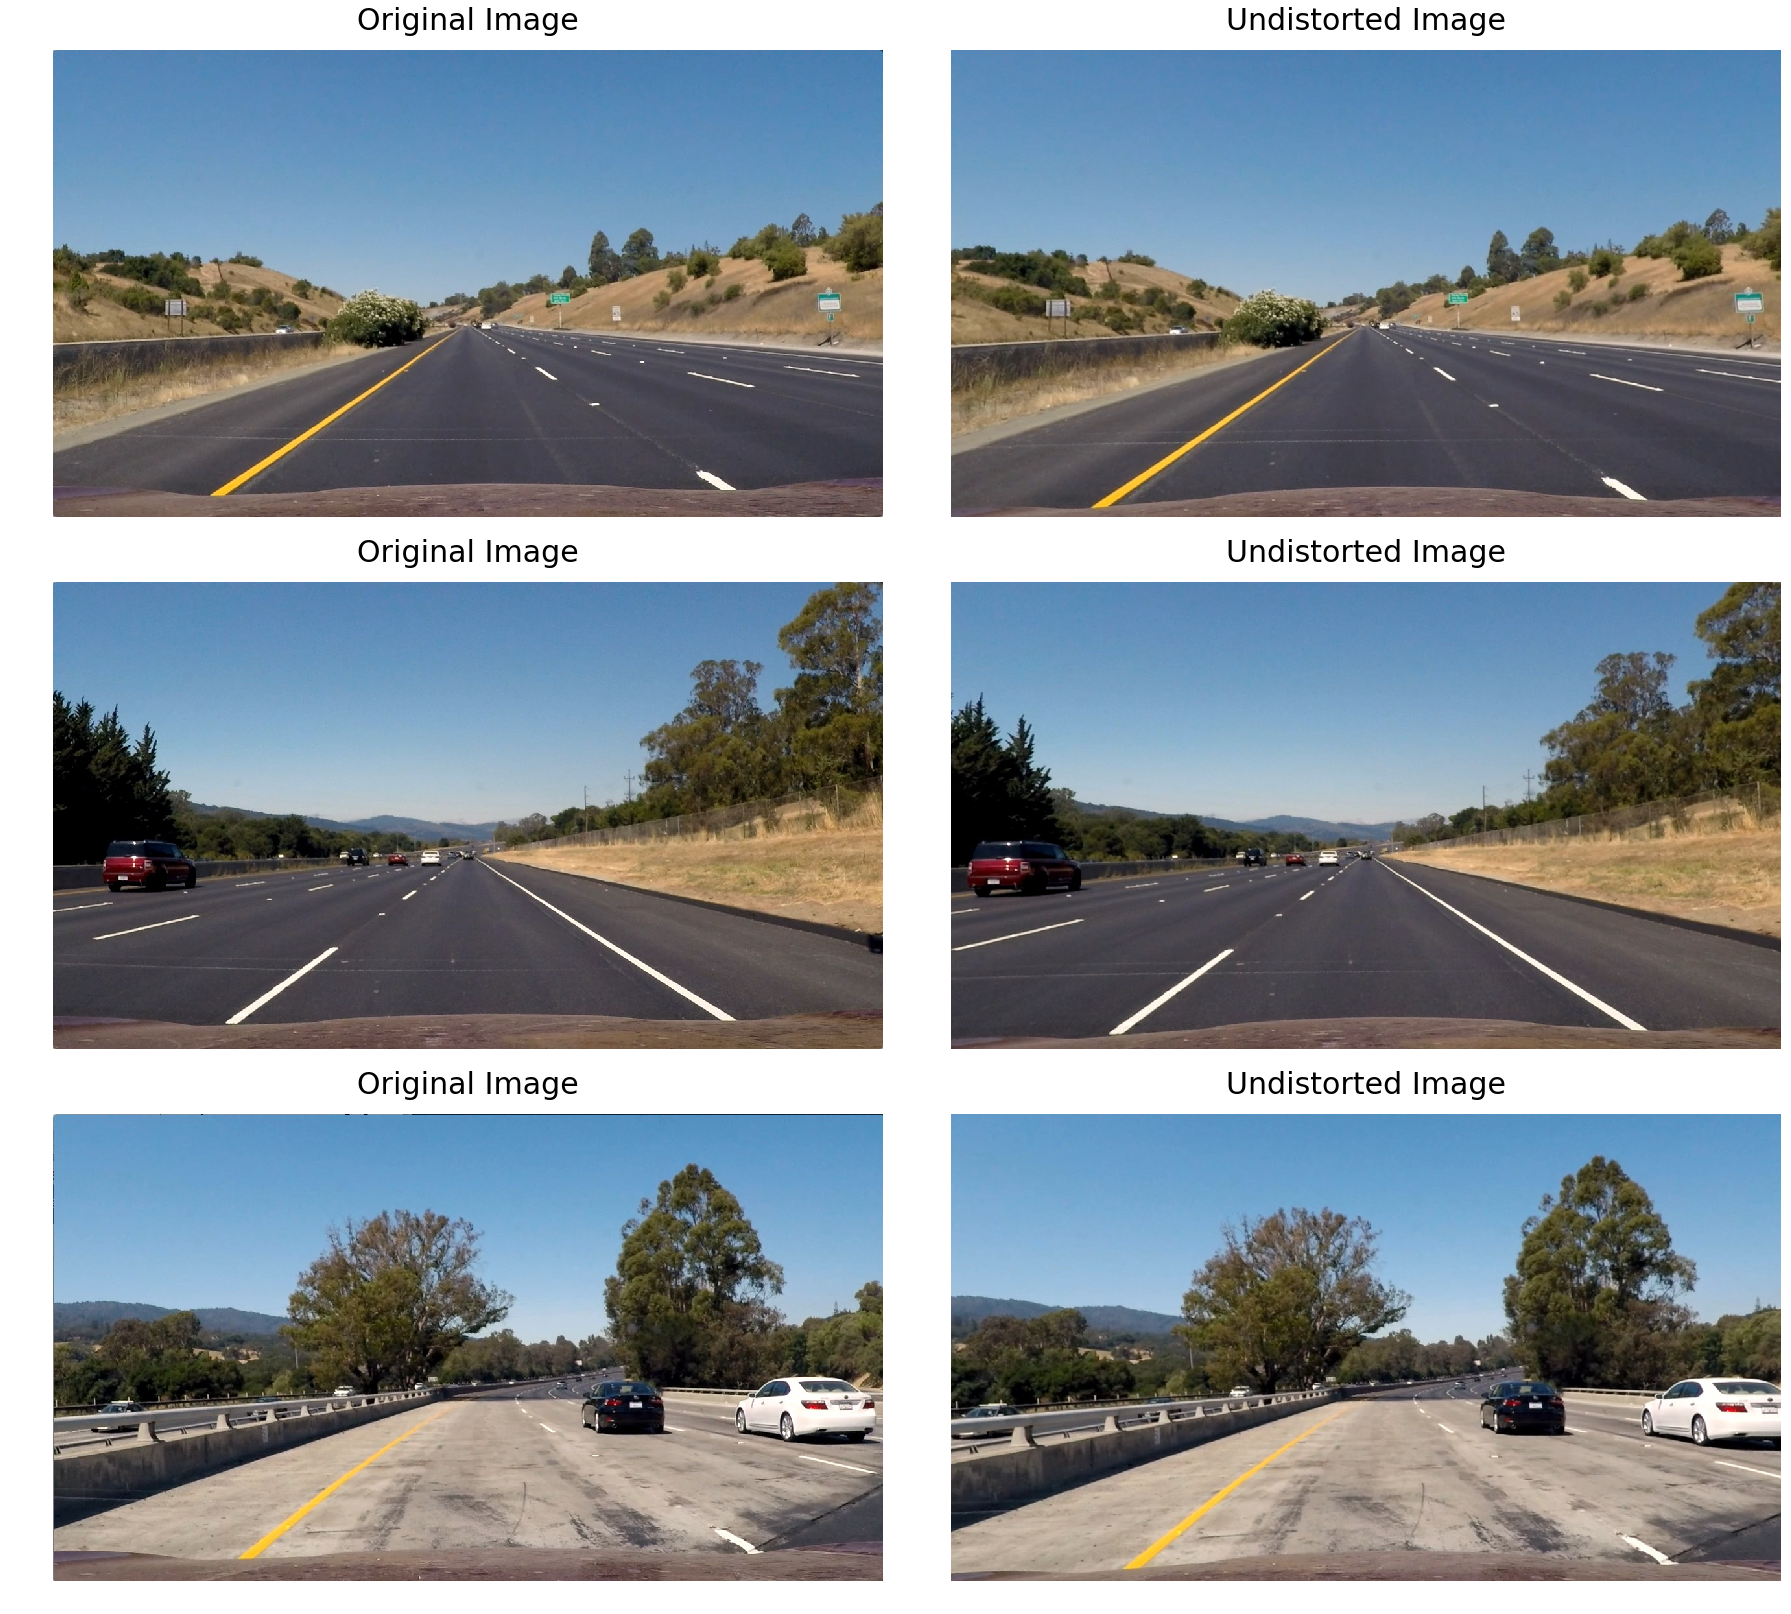

In [50]:
n=3
test_images=os.listdir("test_images/")
titles = ["Original Image", "Undistorted Image"]
fig, ax = plt.subplots(n,2,figsize=(24,24))
fig.tight_layout()

for i in range(0, n):
    image=mpimg.imread("test_images/"+test_images[i])
    undistorted = undistort_image(image)
    ax[i][0].imshow(image,'gray')
    ax[i][0].set_title(titles[0], fontsize=30)
    ax[i][0].axis('off')
    ax[i][1].imshow(undistorted)
    ax[i][1].set_title(titles[1], fontsize=30)
    ax[i][1].axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In the following, we will apply a series of thresholding and color transformations to isolate the lane markings.